In [152]:
# Useful starting lines
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model as sk
from glove_routines import *
from text_classifier import *
from matrix_facto_tester import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def test_embeddings(flag=""):
    #Load the training set
    path_neg = str("data/trainingset_neg"+flag+".npy")
    path_pos = str("data/trainingset_pos"+flag+".npy")
    ts_neg = np.load(path_neg)
    ts_pos = np.load(path_pos)    
    #Train a Linear Classifier: Train a linear classifier (e.g. logistic regression or SVM) on your constructed 
    #features, using the scikit learn library, or your own code from the earlier labs. Recall that the labels 
    #indicate if a tweet used to contain a :) or :( smiley.
    training_set = np.concatenate((ts_neg,ts_pos))
    y = training_set[:,0]
    X = training_set[:,1:np.shape(training_set)[1]]
    X = build_poly(X,2)
    
    #Construct the logistic regressor
    LR = sk.LogisticRegressionCV()
    #LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
    #class_weight=None, random_state=None, solver='liblinear', max_iter=100, multi_class='ovr', verbose=0, 
    #warm_start=False, n_jobs=1)[source]¶
    #http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    #train the logistic regressor
    nsplits = 5
    average_error=0
    kf = ms.KFold(n_splits=nsplits,shuffle=True)
    for train_idx, test_idx in kf.split(X):
        train_set = X[train_idx]
        test_set = X[test_idx]
        train_target = y[train_idx]
        test_target = y[test_idx]    
        LR.fit(train_set,train_target)
        predictions_temp = LR.predict(test_set)
        error = np.sum(np.power(predictions_temp-test_target,2))/np.shape(predictions_temp)[0]
        average_error+=error
    average_error = average_error/nsplits
    return average_error


def test_all_embeddings():
    for subdir, dirs, files in os.walk('embeddings'):
        i=0
        for file in files:
            i+=1
            flag = str("_test_"+str(i))
            print("Constructing features for",file)
            construct_features('embeddings/'+str(file),flag)
            print("   Calculation error")
            error = test_embeddings(flag)
            print("   For file : ",file)
            print("   Error is:",error)
            
test_all_embeddings()

Constructing features for embeddings_emb30_eta0.01_alpha1_nmax800_epochs1.npy
   Calculation error


In [6]:
def construct_features(embeddings_file="data/embeddings.npy", flag_save=""):
    '''
    construct a feature representation of each training tweet 
    (by averaging the word vectors over all words of the tweet).
    '''
    #Load the training tweets and the built GloVe word embeddings.
    pos_train = open('data/pos_train.txt').readlines()
    neg_train = open('data/neg_train.txt').readlines()
    embeddings = np.load(embeddings_file)

    
    #count number of word/tweet and store it
    word_nbr_per_tweet_pos = np.zeros(np.shape(pos_train)[0])
    for j in range(0,np.shape(pos_train)[0]):
        tweet = pos_train[j]
        size = len(re.findall(r'\w+', tweet))
        word_nbr_per_tweet_pos[j] = size
        
    word_nbr_per_tweet_neg = np.zeros(np.shape(neg_train)[0])
    for j in range(0,np.shape(neg_train)[0]):
        tweet = neg_train[j]
        size = len(re.findall(r'\w+', tweet))
        word_nbr_per_tweet_neg[j] = size
    
    i=0
    pos_mask = np.zeros(np.shape(embeddings)[1]+1)
    pos_mask[0] +=1
    #adding 1 at start : this is target (1 is for happy emoji, 0 or -1 for sad face)
    training_set_pos = np.zeros(((np.shape(pos_train)[0],np.shape(embeddings)[1]+1))) + pos_mask
    training_set_neg = np.zeros(((np.shape(neg_train)[0],np.shape(embeddings)[1]+1)))
    vocab = open('data/vocab_cut.txt')
    #for each word, search if it is in pos_train or neg_train
    for word_ in vocab:
        word = word_.split("\n")[0]
        current_emb = embeddings[i]
        for j in range(0,np.shape(pos_train)[0]):
            #if yes, add its embeddings.
            if word in pos_train[j]:
                training_set_pos[j,1:np.shape(embeddings)[1]+1] += current_emb
        for j in range(0,np.shape(neg_train)[0]):
            if word in neg_train[j]:
                training_set_neg[j,1:np.shape(embeddings)[1]+1] += current_emb
        i+=1
    #then divide by number of words (averaging word vector over all words of the tweet)
    for i in range(0,np.shape(embeddings)[1]):
        training_set_pos[:,i+1] = training_set_pos[:,i+1]/word_nbr_per_tweet_pos
        training_set_neg[:,i+1] = training_set_neg[:,i+1]/word_nbr_per_tweet_neg
    np.save(str('data/trainingset_pos')+flag_save, training_set_pos)
    np.save(str('data/trainingset_neg')+flag_save, training_set_neg)
    
def test():
     for subdir, dirs, files in os.walk('embeddings'):
        for file in files:
            print(file)
            assert 0==1
            construct_features("embeddings/"+file)
test()

embeddings_emb100_eta0.01_alpha0.75_nmax150_epochs4.npy


AssertionError: 

227 results found.


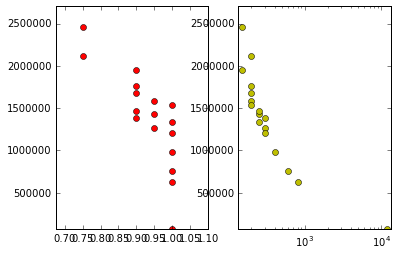

In [120]:
def fix_param(data,idx,value):
    assert ((data[:,idx]==value).any())
    newdata = []
    for i in range(0,np.shape(data)[0]):
        if(data[i,idx]==value):

            newdata.append(data[i])
    #print(newdata)
    return recreate_param(newdata)

def recreate_param(data):
    x = np.shape(data)[0]
    y = np.shape(data)[1]
    param = np.zeros((x,y))
    for i in range(0,x):
        for j in range(0,y):
            param[i,j] = data[i][j]
    return param
from mpl_toolkits.mplot3d import Axes3D
def show_graph():
    embedding_dim = [5, 30, 50, 100, 200]
    for subdir, dirs, files in os.walk('metadata'):
        size = np.shape(files)[0]
        losses = np.zeros(size)
        names = []
        param = []
        i=0
        for file in files:
            f = np.load('metadata/'+str(file))
            losses[i] = f
            names.append(file)
            p = extrac_param(file)
            p.append(f)
            param.append(p)
            i+=1
    print(np.shape(names)[0], "results found.")
    param = recreate_param(param)
    fixed_emb = fix_param(param,0,5)
    fixed_eta = fix_param(fixed_emb,1,0.01)
    xs = fixed_eta[:,2]
    ys = fixed_eta[:,3]
    zs = fixed_eta[:,5]
    plt.figure()
    plt.subplot(121)
    plt.axis([min(xs)*0.9,max(xs)*1.1,min(zs)*0.9,max(zs)*1.1])
    plt.plot(xs,zs,'ro')
    plt.subplot(122)
    plt.xscale('log')
    plt.axis([min(ys)*0.9,max(ys)*1.1,min(zs)*0.9,max(zs)*1.1])

    plt.plot(ys,zs,'yo')
show_graph()